# Covid-19 Booster Vaccination Sentiment Analysis

In [ ]:
#library & package.
#Jalankan ulang jika menambahkan library baru

import pandas as pd, numpy as np, matplotlib.pyplot as plt
import json, tweepy, requests, re
import string, nltk
from datetime import datetime
from dateutil.parser import parse

from bs4 import BeautifulSoup as bs
from urllib.request import urlopen, Request
from datetime import timezone
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud

import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from numpy import array
import tqdm
from pprint import pprint
from PIL import Image
import os
from os import path
from wordcloud import ImageColorGenerator
import stylecloud
from IPython.display import Image

In [ ]:
with open("token.json")as f:
  tokens = json.load(f)

bearer_token = tokens['bearer_token']
api_key = tokens['api_key']
api_key_secret = tokens['api_key_secret']
access_token = tokens['access_token']
access_token_secret = tokens['access_token_secret']

tokens.keys()

dict_keys(['bearer_token', 'api_key', 'api_key_secret', 'access_token', 'access_token_secret'])

# Business Understanding

Berawal dari putusan Jokowi bahwa mulai 12 Januari, Indonesia akan melakukan vaksin booster. Vaksin booster adalah dosis
vaksin tambahan atau bisa dibilang dosis vaksin ketiga, yang dapat melakukan perlindungan ekstra terhadap penyakit COVID-19.
Menurut pemerintah, vaksin booster perlu dilakukan karena adanya penurunan antibodi 6 bulan pasca vaksinasi dosis 2.
Terlebih lagi dengan adanya mutasi virus Delta dan Omicron, membuat pemerintah khawatir akan banyak masyarakat yang terkena
COVID-19 meskipun sudah vaksin.

Tetapi keputusan presiden tersebut pastinya menimbulkan pro kontra. Ada yang setuju maupun tidak. Alasan yang diberikan pun
sangat beragam. Maka dari itu saya ingin mengetahui, berdasarkan data twitter dan data berita yang saya ambil apakah lebih
banyak yang setuju atau tidak mengenai adanya vaksin booster. Disini kita juga dapat melihat kata kunci negatif yang membuat
seseorang setuju maupun tidak setuju mengenai vaksin booster.


In [ ]:
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

# Data Collection

Pada bagian ini saya akan mengambil data dari twitter maupun berita (detik.com) untuk melakukan analisis sentimen berdasarkan data yang ada. Setelah itu data yang sudah saya kumpulkan akan disimpan ke dalam bentuk csv untuk diolah lebih lanjut.

**Mengambil Data Dari Twitter**

Terdiri dari 1600 data dimana 400 data diambil pada masing-masing tanggal, yaitu 23 Januari 2022 - 26 Januari 2022. Hasil dari data saya simpan ke dalam dataframe.

In [ ]:
search_words = "vaksin booster"
new_search = search_words + " -filter:retweets"
untilDate = '2022-01-24'
i = 0
items = []
tanggal = []
for i in range(4):

    if(i == 0):
        untilDate = '2022-01-24'
    elif(i== 1):
        untilDate = '2022-01-25'
    elif(i==2):
        untilDate = '2022-01-26'
    else:
        untilDate = '2022-01-27'
    i=+1
    for tweet in tweepy.Cursor(api.search_tweets,
            q=new_search,
            until= untilDate,
            tweet_mode="extended",
            lang="id").items(400):
        tanggal.append(tweet.created_at)
        items.append(' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet.full_text).split()))


In [ ]:
hasil = pd.DataFrame(
    {'date': tanggal,
     'data': items
    })

In [ ]:
hasil['date'] = hasil.date.apply(lambda x: x.date())
hasil

,date,data
0,2022-01-23,Wagub DKI Ajak Warga Ikut Vaksin Booster
1,2022-01-23,pakisaji Puskesmas Pakisaji Malang mengadakan ...
2,2022-01-23,Selamat pagi para admin sosmed RS yang menyedi...
3,2022-01-23,Gmn ini d inggris aja udah d cabut aturan pand...
4,2022-01-23,Alhamdulillah vaksin booster atau ke 3 di RSUD...
...,...,...
1595,2022-01-26,Abis vaksin booster kuat ngegym gak yah kira2
1596,2022-01-26,Alhamdulillah udah vaksin booster 3 Prifizer M...
1597,2022-01-26,Mendukung program pemerintah dalam percepatan ...
1598,2022-01-26,Iya baru beredar di grup ada yg kena Mbak Mita...


**Mengambil Data Dari Web Berita Detik.com**

Terdiri dari 19 data dengan berita mengenai vaksin booster pada tanggal 23 Januari 2022 - 26 Januari 2022. Hasil dari data saya simpan ke dalam dataframe.

In [ ]:
#Web Scraping
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.99 Safari/537.36'
headers = {
    'user_agent': user_agent,
    'accept':'*/*'
}
newsAll = []
dateAll = []
for i in range(3):
    alamat = 'https://www.detik.com/search/searchall?query=vaksin%20booster&siteid=3&sortby=time&fromdatex=23/01/2022&todatex=26/01/2022&page='+str(i+1)
    data_request = Request(alamat, headers=headers)
    response = urlopen(data_request)
    soup = bs(response, 'html.parser')
    news_title = soup.find_all('h2', {'class':'title'})
    date_title = soup.find_all('span', {'class':'date'})
    news = [newsAll.append(title.getText()) for title in news_title]
    dates = [dateAll.append(date.getText()) for date in date_title]

newsAll = pd.DataFrame({
    'date' : dateAll,
    'data' : newsAll
})

In [ ]:
newsAll['date'] = newsAll['date'].map(lambda x: str(x)[15:-10])
newsAll['date'] = pd.to_datetime(newsAll['date']).dt.date
newsAll

,date,data
0,2022-01-26,Alur Vaksin Covid Booster: Mulai Cek Tiket-Pen...
1,2022-01-26,"Lokasi Vaksin Booster di Bandung, Catat Syarat..."
2,2022-01-25,Satpol PP Makassar Diterjunkan Ajak Lansia Vak...
3,2022-01-25,"Pendaftaran Vaksin Booster Lewat JAKI, Cek di ..."
4,2022-01-25,Booster Vaksin Sinovac Bisa Pakai AstraZeneca-...
5,2022-01-25,"2 Orang Positif Omicron, Bupati Karawang: Kare..."
6,2022-01-25,"Omicron Melonjak, Ombudsman Minta Ridwan Kamil..."
7,2022-01-25,Vaksinasi Booster Belum Dilaksanakan di Ciamis...
8,2022-01-25,"Corona di DKI Melonjak, Anggota DPRD Minta Pem..."
9,2022-01-24,Jumlah Kasus dan Pasien COVID-19 di Rumah Saki...


**Menggabungkan hasil raw data**

Raw data atau data mentah yang berasal dari twitter dan berita digabungkan menjadi satu dataframe dengan mengurutkan data
berdasarkan tanggal untuk mempermudah pembacaan data. Setelah itu lalu data mentah disimpan dalam format csv dengan nama rawdata_proyekakhir.csv.

In [ ]:
#Gabungan Raw Data
rawData = pd.concat([hasil, newsAll], axis=0)
rawData.rename({'data': 'raw_data'}, axis=1, inplace=True)
rawData = rawData.sort_values(by="date").reset_index(drop=True)
rawData

,date,raw_data
0,2022-01-23,Wagub DKI Ajak Warga Ikut Vaksin Booster
1,2022-01-23,Seram juga nak amik booster ni Masa amik vaksi...
2,2022-01-23,vaksinmalang vaksin booster PFIZER umur 18 yg ...
3,2022-01-23,Ga punya foto pas tadi divaksin booster Punyan...
4,2022-01-23,Bukan untuk booster kak tapi vaksin pertama da...
...,...,...
1614,2022-01-26,Repost bpn kementerian atrbpn Halo SobATRBPN s...
1615,2022-01-26,Vaksin Booster bagi para pegawai di lingkungan...
1616,2022-01-26,Pemberian vaksin booster dapat menurunkan risi...
1617,2022-01-26,I took my booster dose and I m okay alhamdulil...


In [ ]:
rawData.to_csv('rawdata_proyekakhir.csv', index=False)

# Data Preparation

Pada bagian ini saya akan melakukan validasi terhadap data mentah. Hal ini berarti akan dilakukan pemmbersihan data untuk data yang sekiranya tidak diperlukan untuk proses analisa. Hal yang saya lakukan pada data preparation antara lain:

Text Preprosessing :  
* Handling data duplikat  
* Case Folding  
* Slang Words Remover  
* Stop Words Remover  

In [ ]:
#Data Preparation
rawData = pd.read_csv("rawdata_proyekakhir.csv")
rawData

,date,raw_data
0,2022-01-23,Wagub DKI Ajak Warga Ikut Vaksin Booster
1,2022-01-23,Seram juga nak amik booster ni Masa amik vaksi...
2,2022-01-23,vaksinmalang vaksin booster PFIZER umur 18 yg ...
3,2022-01-23,Ga punya foto pas tadi divaksin booster Punyan...
4,2022-01-23,Bukan untuk booster kak tapi vaksin pertama da...
...,...,...
1614,2022-01-26,Repost bpn kementerian atrbpn Halo SobATRBPN s...
1615,2022-01-26,Vaksin Booster bagi para pegawai di lingkungan...
1616,2022-01-26,Pemberian vaksin booster dapat menurunkan risi...
1617,2022-01-26,I took my booster dose and I m okay alhamdulil...


**Melakukan Handling Data Duplikat**

Data duplikat perlu dihapus untuk menghindari duplikasi dari analisis sentimen yang membuat hasil analisis tidak akurat. Diketahui terdapat 93 data duplikat yang perlu dihapus. Setelah itu data akan diurutkan kembali berdasarkan index baru yang menghasilkan 1526 data.

In [ ]:
#Melakukan handling data duplicate
duplicate = rawData.duplicated()
print(duplicate.sum())
rawData[duplicate]

93


,date,raw_data
56,2022-01-23,Polsek Bekasi Timur Dirikan Gerai Vaksin Boost...
60,2022-01-23,Catat Lokasi Vaksin Booster di Jakarta dan Bod...
63,2022-01-23,Seribu Dosis Vaksin Booster Disiapkan Pada Car...
69,2022-01-23,COVID19 booster shot adverse event reports Lap...
103,2022-01-23,Batam Sebanyak 600 Aparatur Sipil Negara ASN d...
...,...,...
1467,2022-01-26,Vaksin Booster Heterolog setengah dosis lebih ...
1488,2022-01-26,Koordinasi Vaksin Booster Kakanwil Kemenkunham...
1509,2022-01-26,Jadwal dan Lokasi Vaksin Booster Kemendikbudri...
1526,2022-01-26,Koordinasi Vaksin Booster Kakanwil Kemenkunham...


In [ ]:
#Karena adanya beberapa data duplikat, maka saya memutuskan untuk menghapus data duplikast tersebut
rawData.drop_duplicates(inplace = True)
duplicate = rawData.duplicated()
print(duplicate.sum())

0


In [ ]:
rawData.reset_index(drop=True, inplace=True)
rawData

,date,raw_data
0,2022-01-23,Wagub DKI Ajak Warga Ikut Vaksin Booster
1,2022-01-23,Seram juga nak amik booster ni Masa amik vaksi...
2,2022-01-23,vaksinmalang vaksin booster PFIZER umur 18 yg ...
3,2022-01-23,Ga punya foto pas tadi divaksin booster Punyan...
4,2022-01-23,Bukan untuk booster kak tapi vaksin pertama da...
...,...,...
1521,2022-01-26,Repost bpn kementerian atrbpn Halo SobATRBPN s...
1522,2022-01-26,Vaksin Booster bagi para pegawai di lingkungan...
1523,2022-01-26,Pemberian vaksin booster dapat menurunkan risi...
1524,2022-01-26,I took my booster dose and I m okay alhamdulil...


**Melakukan Case Fodling, Slang Remover, dan Stopwords Remover**

* Case Folding : membuat data menjadi huruf kecil, menghilangkan karakter khusus dan angka pada data, dan menghapus tanda    baca.

* Slang Remover : mengganti kata slang dengan kata yang baku sesuai dengan KBBI. Hal ini dikarenakan banyak dari pengguna twitter yang tidak menggunakan bahasa baku, sehingga dapat menimbulkan kerancauan arti. Data slang list saya dapatkan berdasarkan kata yang sering keluar pada data analytics.

* Stop Words Remover : menghilangkan kata yang tidak berarti pada analisis sentimen, seperti dan, di, dari, dsb. Untuk melakukan stop words removal, perlu melakukan tokenizing terlebih dahulu. Tokenizing adalah teknik pemisahan kalimat menjadi satu per kata seperti token.

In [ ]:
class preprocessing:
    def case_folding(self, data):
        data = data.lower()
        data = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", data).split())
        data = re.sub(r"\d+", "", data)
        data = data.translate(str.maketrans("","",string.punctuation))
        data = re.sub(r"\n+", "", data)
        return data

    def tokenizing(self, data):
        data = word_tokenize(data)
        return data

    def slang_remover(self, data, slang_list:list=[]):
        word_token = self.tokenizing(data)
        word_list = []

        for word in word_token:
            for slang in slang_list:
                if word.lower() in slang[0].lower():
                    word = slang[1]
                    break
            word_list.append(word)

        data = ' '.join(word_list)
        return data

    def stopwords(self, data) :
        stop_words = set(stopwords.words('indonesian'))
        negasi = ['tidak']
        stop_words = [word for word in stop_words if word not in negasi]
        data = ' '.join([w for w in data if w not in stop_words])
        return data

In [ ]:
pp = preprocessing()
slang_list = [
    ("yg","yang"),
    ("udah","sudah"),
    ("dah","sudah"),
    ("udh","sudah"),
    ("ya","iya"),
    ("ga","tidak"),
    ("aja","saja"),
    ("abis","habis"),
    ("gak","tidak"),
    ("ni","ini"),
    ("kalo","kalau"),
    ("gue","saya"),
    ("dapet","dapat"),
    ("amp",""),
    ("tau","tahu"),
    ("tp","tapi"),
    ("bgt","banget"),
    ("gw","saya"),
    ("nya",""),
    ("gara","karena"),
    ("je","japanese encephalitis"),
    ("x",""),
    ("org","orang"),
    ("mcm","macam"),
    ("blm","belum"),
    ("and","dan"),
    ("effect","efek"),
    ("nak","ingin"),
    ("pengen","ingin"),
    ("tu","itu"),
    ("sih",""),
    ("kak","kakak"),
    ("dose","dosis"),
    ("tuh",""),
    ("nih",""),
    ("lg","lagi"),
    ("dpt","dapat"),
]

rawData['clean_data'] = rawData['raw_data'].apply(lambda x:pp.case_folding(x))
rawData['clean_data'] = rawData['clean_data'].apply(lambda x:pp.slang_remover(x, slang_list))
rawData['clean_data'] = rawData['clean_data'].apply(lambda x:pp.tokenizing(x))
rawData['clean_data'] = rawData['clean_data'].apply(lambda x:pp.stopwords(x))
rawData.reset_index(drop=True, inplace=True)

rawData

,date,raw_data,clean_data
0,2022-01-23,Wagub DKI Ajak Warga Ikut Vaksin Booster,wagub dki ajak warga vaksin booster
1,2022-01-23,Seram juga nak amik booster ni Masa amik vaksi...,seram amik booster amik vaksin dosis main sema...
2,2022-01-23,vaksinmalang vaksin booster PFIZER umur 18 yg ...,vaksinmalang vaksin booster pfizer umur sdh ti...
3,2022-01-23,Ga punya foto pas tadi divaksin booster Punyan...,tidak foto pas divaksin booster punyanya foto ...
4,2022-01-23,Bukan untuk booster kak tapi vaksin pertama da...,booster kakak vaksin
...,...,...,...
1521,2022-01-26,Repost bpn kementerian atrbpn Halo SobATRBPN s...,repost bpn kementerian atrbpn halo sobatrbpn p...
1522,2022-01-26,Vaksin Booster bagi para pegawai di lingkungan...,vaksin booster pegawai lingkungankementerian a...
1523,2022-01-26,Pemberian vaksin booster dapat menurunkan risi...,pemberian vaksin booster menurunkan risiko raw...
1524,2022-01-26,I took my booster dose and I m okay alhamdulil...,habis took my booster dosis habis okay alhamdu...


**Melakukan Pengecekan Data Kosong**

In [ ]:
rawData.isnull().sum()

date          0
raw_data      0
clean_data    0
dtype: int64

# Data Processing

Terdiri dari 3 tahap yaitu :
* Text Data Analytics
* Topic Extraction & Analysis
* Sentiment Analysis

**Text Data Analytics**

In [ ]:
class data_analytic:

    def frekuensi_karakter(self, data):
        bin_range = np.arange(0, 260, 10)
        data.str.len().hist(bins=bin_range, color = "turquoise", ec = "black")
        plt.xlabel('Karakter per Data')
        plt.ylabel('Jumlah')
        plt.title('Distribusi Frekuensi Jumlah Karakter per Data')
        plt.show()

    def frekuensi_kata(self,data):
        bin_range = np.arange(0, 50)
        data.str.split().map(lambda x: len(x)).hist(bins=bin_range, color = "turquoise", ec = "black")
        data.str.len().hist(bins=bin_range, color = "turquoise", ec = "black")
        plt.xlabel('Kata per Data')
        plt.ylabel('Jumlah')
        plt.title('Distribusi Frekuensi Jumlah Kata per Data')
        plt.show()

    def frekuensi_panjang_kata(self,data):
        data.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(color = "turquoise", ec = "black")
        plt.xlabel('Panjang Kata Rata-Rata Pada Data')
        plt.ylabel('Jumlah')
        plt.title('Distribusi Frekuensi Panjang Kata Rata-Rata Pada Data')
        plt.show()

    def most_common_words(self, data):
        data = data.apply(lambda x:pp.tokenizing(x))
        words = [w for words in data for w in words]
        fqdist = FreqDist(words)
        most_common_word = fqdist.most_common(20)
        fqdist.plot(20,cumulative=False, color = "turquoise")
        plt.show()
        return most_common_word

    def hasil_bigram(self,data):
        databi = data.apply(lambda x:pp.tokenizing(x))
        words = [w for words in databi for w in words]
        result = pd.Series(nltk.ngrams(words, 2)).value_counts()[:20]
        return result

**Distribusi Frekuensi Jumlah Karakter per Data**
Berdasarkan grafik dibawah, dapat dilihat distribusi terbanyak berada pada 40 - 60 karakter per data. Dengan data yang memiliki panjang diatas 125 karakter, setiap nilainya tidak lebih dari 50 data.

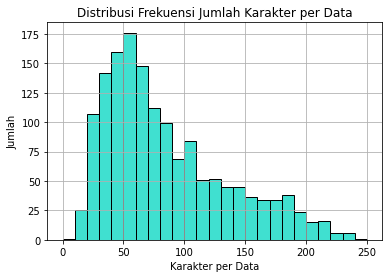

In [ ]:
da = data_analytic()

#Distribusi Frekuensi Jumlah Karakter per Data
da.frekuensi_karakter(rawData['clean_data'])

**Distribusi Frekuensi Jumlah Kata per Data**  
Berdasarkan grafik dibawah, dapat dilihat bahwa distribusi terbanyak berada pada 5 - 10 kata per data. Data dengan jumlah kata di atas 15 bisa dibilang tidak terlalu banyak.

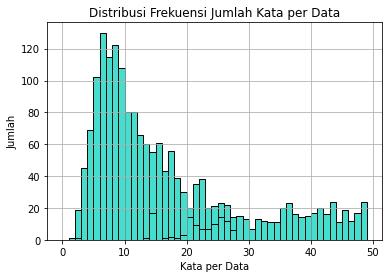

In [ ]:
#Distribusi Frekuensi Jumlah Kata per Data
da.frekuensi_kata(rawData['clean_data'])

**Distribusi Frekuensi Panjang Kata Rata-Rata Pada Data**  
Berdasarkan grafik dibawah, dapat dilihat bahwa distribusi terbanyak berada pada 5 - 7 karakter per kata per data. Jumlah huruf pada kata yang umum ada pada bahasa indonesia.

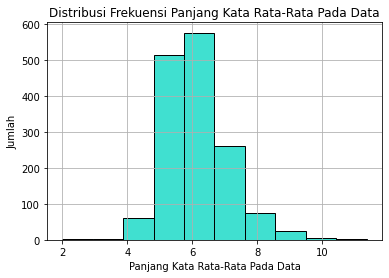

In [ ]:
#Distribusi Frekuensi Panjang Kata Rata-Rata Pada Data
da.frekuensi_panjang_kata(rawData['clean_data'])

Dari ketiga analisis diatas, dapat disimpulkan bahwa mayoritas data berada pada 5 - 10 kata dengan setiap kata berada di antara 5 - 7 karakter dan total 40 - 60 karakter pada data.

**Distribusi Frekuensi Kata yang Sering Keluar**  
Dari grafik dibawah, kita bisa melakukan analisis secara kasar tentang bagaimana fitur yang dimiliki oleh data yang kita ambil. Frekuensi kata yang sering keluar juga dapat menjadi acuan dalam melakukan penghapusan slang words. Dari data yang ada, diketahui 20 kata yang sering muncul dan frekuensi kemunculan kata tersebut.

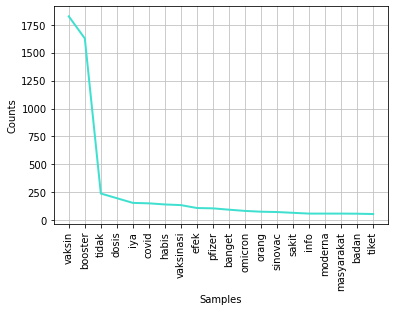

[('vaksin', 1826), ('booster', 1628), ('tidak', 238), ('dosis', 196), ('iya', 154), ('covid', 150), ('habis', 140), ('vaksinasi', 134), ('efek', 108), ('pfizer', 105), ('banget', 93), ('omicron', 82), ('orang', 75), ('sinovac', 72), ('sakit', 65), ('info', 58), ('moderna', 58), ('masyarakat', 58), ('badan', 57), ('tiket', 54)]


In [ ]:
#Distribusi Frekuensi kata yang sering keluar
most_common = da.most_common_words(rawData['clean_data'])
print(most_common)

**Distribusi N-Gram**  
Distribusi N-gram adalah teknik pemotongan kata sebanyak N kata. Untuk pemotongan setiap dua kata disebut dengan bi-gram. Disini saya melakukan bi gram, yaitu pemotongan dua data dengan total hasil sebanyak 20 data. Berdasarkan data yang diperoleh, kita dapat mengetahui bahwa keseluruhan data membicarakan mengenai info, efek, dan ketersediaan vaksin booster.

In [ ]:
#Distribusi N-Gram
hasil_bi = da.hasil_bigram(rawData['clean_data'])
print(hasil_bi)

(vaksin, booster)           1066
(booster, vaksin)            177
(habis, vaksin)               81
(vaksinasi, booster)          58
(vaksin, dosis)               46
(efek, vaksin)                41
(booster, pfizer)             40
(vaksin, covid)               40
(tiket, vaksin)               32
(vaksin, sinovac)             32
(booster, moderna)            29
(booster, dosis)              29
(dosis, vaksin)               26
(japanese, encephalitis)      23
(booster, covid)              22
(dosis, ketiga)               22
(vaksin, vaksin)              22
(info, vaksin)                21
(lokasi, vaksin)              20
(peduli, lindungi)            19
dtype: int64


**Topic Extraction & Analysis**  
Teknik yang dilakukan untuk melakukan struktur ulang teks dan mencari pola yang ada pada kalimat dan membaginya menjadi beberapa topik. Pada tahap ini saya melakukan topic modelling dengan teknik unsupervised, yaitu mencari topik berdasarkan pola dari data yang dimiliki.

In [ ]:
#Melakukan modelling untuk mengetahui inti berita dari kata kunci 'vaksin booster'
data_modelling = [berita.split() for berita in rawData['clean_data']]

In [ ]:
dictionary = corpora.Dictionary(data_modelling)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_modelling]

In [ ]:
#Mencoba mengambil 5 topik dari data yang ada
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(
    random_state=100,
    chunksize=100,
    per_word_topics=True,
    corpus = doc_term_matrix,
    num_topics=5,
    id2word = dictionary,
    passes=50
    )

In [ ]:
pprint(ldamodel.print_topics())

[(0,
  '0.070*"vaksin" + 0.066*"booster" + 0.030*"habis" + 0.022*"tidak" + '
  '0.015*"sakit" + 0.015*"efek" + 0.013*"badan" + 0.012*"pfizer" + '
  '0.008*"pegel" + 0.008*"tangan"'),
 (1,
  '0.085*"vaksin" + 0.079*"booster" + 0.021*"banget" + 0.018*"covid" + '
  '0.016*"omicron" + 0.009*"besok" + 0.009*"masyarakat" + 0.009*"lansia" + '
  '0.009*"pemerintah" + 0.008*"anak"'),
 (2,
  '0.070*"vaksin" + 0.058*"booster" + 0.019*"sinovac" + 0.014*"covid" + '
  '0.013*"varian" + 0.011*"demam" + 0.010*"dosis" + 0.008*"suntik" + '
  '0.008*"tidak" + 0.008*"terima"'),
 (3,
  '0.095*"vaksin" + 0.087*"booster" + 0.024*"iya" + 0.012*"tidak" + '
  '0.010*"daftar" + 0.010*"kakak" + 0.009*"tiket" + 0.008*"jadwal" + '
  '0.007*"cek" + 0.007*"lokasi"'),
 (4,
  '0.057*"vaksin" + 0.056*"booster" + 0.023*"vaksinasi" + 0.015*"info" + '
  '0.014*"dosis" + 0.013*"yuk" + 0.009*"iya" + 0.008*"ketiga" + 0.008*"kota" + '
  '0.007*"puskesmas"')]


In [ ]:
coherence_model_lda = CoherenceModel(model=ldamodel, texts=data_modelling, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.319987795849786


In [ ]:
def compute_coherence_values(corpus, dictionary, k, a, b):

    lda_model = gensim.models.LdaMulticore(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=k,
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_modelling, dictionary=dictionary, coherence='c_v')

    return coherence_model_lda.get_coherence()

In [ ]:
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25),
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5),
               gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75),
               doc_term_matrix]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)

    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary,
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)

                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████| 540/540 [5:33:18<00:00, 37.03s/it]


In [ ]:
df_tuning_result = pd.read_csv("lda_tuning_results.csv")
df_tuning_result

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.254583
1,75% Corpus,2,0.01,0.31,0.296654
2,75% Corpus,2,0.01,0.61,0.249457
3,75% Corpus,2,0.01,0.9099999999999999,0.261692
4,75% Corpus,2,0.01,symmetric,0.243753
...,...,...,...,...,...
535,100% Corpus,10,asymmetric,0.01,0.321274
536,100% Corpus,10,asymmetric,0.31,0.384565
537,100% Corpus,10,asymmetric,0.61,0.410210
538,100% Corpus,10,asymmetric,0.9099999999999999,0.344132


Berdasarkan grafik, diperoleh topik yang nilainya tinggi bernilai 7, maka saya akan membagi data menjadi 7 topik. Dapat dilihat juga bahwa nilai coherence jika topik dibagi 7 lebih besar daripada nilai coherence apabila topik dibagi menjadi 5.

<AxesSubplot:xlabel='Topics'>

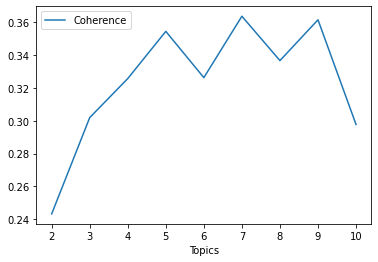

In [ ]:
df_plot = df_tuning_result[(df_tuning_result.Alpha == "0.01") & (df_tuning_result.Beta == "0.31") & (df_tuning_result.Validation_Set == "100% Corpus")].copy()
df_plot.plot(x='Topics', y = "Coherence", kind="line")

In [ ]:
df_plot_2 = df_tuning_result[(df_tuning_result.Topics == 7) & (df_tuning_result.Validation_Set == "100% Corpus")].copy()
df_plot_2.sort_values(by="Coherence", ascending=False)

,Validation_Set,Topics,Alpha,Beta,Coherence
433,100% Corpus,7,0.61,0.9099999999999999,0.407091
438,100% Corpus,7,0.9099999999999999,0.9099999999999999,0.406908
427,100% Corpus,7,0.31,0.61,0.386659
448,100% Corpus,7,asymmetric,0.9099999999999999,0.385999
432,100% Corpus,7,0.61,0.61,0.383664
441,100% Corpus,7,symmetric,0.31,0.381809
434,100% Corpus,7,0.61,symmetric,0.376479
424,100% Corpus,7,0.01,symmetric,0.375568
444,100% Corpus,7,symmetric,symmetric,0.371701
447,100% Corpus,7,asymmetric,0.61,0.369924


In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=7,
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.6,
                                           eta=0.9)

pprint(lda_model.print_topics())

[(0,
  '0.050*"vaksin" + 0.046*"booster" + 0.015*"habis" + 0.009*"banget" + '
  '0.008*"sakit" + 0.008*"efek" + 0.006*"pfizer" + 0.006*"badan" + '
  '0.005*"pegel" + 0.005*"tangan"'),
 (1,
  '0.053*"vaksin" + 0.047*"booster" + 0.017*"dosis" + 0.011*"covid" + '
  '0.010*"vaksinasi" + 0.005*"masyarakat" + 0.005*"anak" + 0.004*"ketiga" + '
  '0.003*"cek" + 0.003*"halal"'),
 (2,
  '0.004*"vaksin" + 0.004*"booster" + 0.003*"kayak" + 0.002*"beliau" + '
  '0.002*"update" + 0.001*"dosen" + 0.001*"biarlah" + 0.001*"gk" + 0.001*"war" '
  '+ 0.001*"yesterday"'),
 (3,
  '0.017*"vaksin" + 0.016*"booster" + 0.006*"orang" + 0.006*"tidak" + '
  '0.003*"disuntik" + 0.003*"kipi" + 0.003*"sy" + 0.003*"kena" + 0.003*"klo" + '
  '0.002*"berita"'),
 (4,
  '0.007*"booster" + 0.006*"vaksin" + 0.003*"sdh" + 0.002*"kuat" + '
  '0.002*"adek" + 0.002*"tdk" + 0.002*"masker" + 0.002*"butter" + '
  '0.001*"omicron" + 0.001*"kelas"'),
 (5,
  '0.035*"vaksin" + 0.035*"booster" + 0.005*"lansia" + 0.005*"kota" + '
  '0.0

**Hasil Topic Extraction & Analysis**  
Hal yang dapat saya ambil berdasarkan masing-masing topik:

    1. Efek setelah vaksin booster antara lain badan dan tangan terasa sakit dan pegal
    2. Vaksin booster merupakan vaksin dosis ketiga dan dapat dicek halal
    3. Update vaksin booster oleh dosen
    4. Kejadian Ikutan Pasca Imunisasi (KIPI) pada orang yang telah disuntik vaksin booster
    5. Vaksin booster kuat menangani omicron
    6. Lokasi vaksin booster untuk lansia
    7. Tiket vaksin booster daerah jabodetabek

**Sentiment Analysis**  
Sentiment Analysis adalah kegiatan dalam menganalisa dan menilai suatu sentimen dalam sebuah kalimat. Dalam data science dan business intelegent ini merupakan salah satu hal yang penting karena kita dapat menilai reaksi masyarakat terhadap suatu produk/topik melalui opini yang mereka keluarkan. Dari sini kita akan melihat sentimen masyarakat terhadap adanya vaksin booster.

In [ ]:
#Persiapan data untuk melakukan sentiment analysis
hasilList = rawData['clean_data'].tolist()

Pada code dibawah, kita akan menentukan sentimen yang ada pada setiap kalimat pada data. Disini kata akan dibedah satu persatu untuk menentukan apakah suatu data positif atau negatif. Perhitungan penentuan apakah suatu data positif atau negatif dapat dilihat melalui perhitungan nilai positif - nilai negatif. Apabila hasil dari rumus tersebut adalah 0 maka hasilnya adalah netral, apabila lebih dari 0 maka hasilnya positif, dan apabila kurang dari 0 maka hasilnya negatif.

In [ ]:
#Sentiment Analysis
#Lakukan Sentiment Analysis
#masukkan hasilnya pada dataframe dengan nama kolom "sentiment"

rawData['sentiment'] = ""
text = []
i=0
pos_list= open("./kata_positif.txt","r")
pos_kata = pos_list.readlines()
neg_list= open("./kata_negatif.txt","r")
neg_kata = neg_list.readlines()
list_anti = ['tidak','lawan','anti', 'belum', 'belom', 'tdk', 'jangan', 'gak', 'enggak', 'bukan', 'sulit', 'tak', 'sblm']
for item in hasilList:
    print(item.strip())
    tweets = item.strip().split() #tokenization

    count_p = 0 #nilai positif
    count_n = 0 #nilai negatif

    for tweet in tweets:
        for kata_pos in pos_kata:
            if kata_pos.strip().lower() == tweet.lower():
                if hasilList[hasilList.index(item)-1] in list_anti:
                    print(hasilList[hasilList.index(item)-1], kata_pos, ['negatif'])
                    count_n += 1
                else:
                    print(kata_pos, ['positif'])
                    count_p += 1
        for kata_neg in neg_kata:
            if kata_neg.strip().lower() == tweet.lower():
                if hasilList[hasilList.index(item)-1] in list_anti:
                    print(hasilList[hasilList.index(item)-1], kata_neg, ['positif'])
                    count_p += 1
                else:
                    print(kata_neg, ['negatif'])
                    count_n += 1

    print ("positif: "+str(count_p))
    print ("negatif: "+str(count_n))
    text.append(count_p - count_n)
    score = count_p - count_n
    if(score==0):
        kalimat = 'Netral'
    elif (score>0):
        kalimat = 'Positif'
    elif(score<0):
        kalimat = 'Negatif'
    print(hasilList.index(item))
    rawData['sentiment'][i] = kalimat
    i+=1


In [ ]:
print ("Nilai rata-rata: "+str(np.mean(text)))
print ("Standar deviasi: "+str(np.std(text)))

Nilai rata-rata: 0.05111402359108781
Standar deviasi: 1.1641243583612295


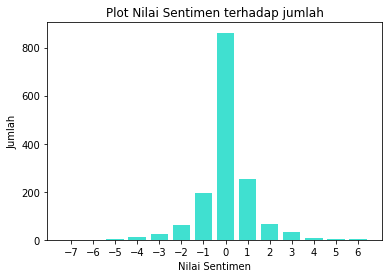

In [ ]:
labels, counts = np.unique(text, return_counts=True)
plt.bar(labels, counts, align='center', color = "turquoise")
plt.gca().set_xticks(labels)
plt.title("Plot Nilai Sentimen terhadap jumlah")
plt.xlabel('Nilai Sentimen')
plt.ylabel('Jumlah')
plt.show()

Nilai sentimen rata-rata berada di atas 0 yang menyatakan bahwa nilai positif

In [ ]:
#Hasil data setelah melakukan analisis sentimen
rawData

,date,raw_data,clean_data,sentiment
0,2022-01-23,Wagub DKI Ajak Warga Ikut Vaksin Booster,wagub dki ajak warga vaksin booster,Netral
1,2022-01-23,Seram juga nak amik booster ni Masa amik vaksi...,seram amik booster amik vaksin dosis main sema...,Positif
2,2022-01-23,vaksinmalang vaksin booster PFIZER umur 18 yg ...,vaksinmalang vaksin booster pfizer umur sdh ti...,Netral
3,2022-01-23,Ga punya foto pas tadi divaksin booster Punyan...,tidak foto pas divaksin booster punyanya foto ...,Netral
4,2022-01-23,Bukan untuk booster kak tapi vaksin pertama da...,booster kakak vaksin,Netral
...,...,...,...,...
1521,2022-01-26,Repost bpn kementerian atrbpn Halo SobATRBPN s...,repost bpn kementerian atrbpn halo sobatrbpn p...,Netral
1522,2022-01-26,Vaksin Booster bagi para pegawai di lingkungan...,vaksin booster pegawai lingkungankementerian a...,Netral
1523,2022-01-26,Pemberian vaksin booster dapat menurunkan risi...,pemberian vaksin booster menurunkan risiko raw...,Negatif
1524,2022-01-26,I took my booster dose and I m okay alhamdulil...,habis took my booster dosis habis okay alhamdu...,Positif


**Data Positif**  
Setelah dikelompokkan, ada 365 data yang mengeluarkan hasil sentimen positif

In [ ]:
#Data positif
data_positif = rawData[rawData['sentiment'] == 'Positif']
data_positif.reset_index(drop=True, inplace=True)
data_positif

,date,raw_data,clean_data,sentiment
0,2022-01-23,Seram juga nak amik booster ni Masa amik vaksi...,seram amik booster amik vaksin dosis main sema...,Positif
1,2022-01-23,kak je aku blm vaksin booster tolong ini gak s...,kakak japanese encephalitis vaksin booster tol...,Positif
2,2022-01-23,adek kuat mas udah vaksin 2x sekalian sama boo...,adek kuat mas vaksin booster,Positif
3,2022-01-23,BPOM RI telah mengeluarkan izin penggunaan dar...,bpom ri mengeluarkan izin penggunaan darurat m...,Positif
4,2022-01-23,estewe2022 lifes memoryusang ofjuly dsp89 070 ...,estewe lifes memoryusang ofjuly dsp met ngopi ...,Positif
...,...,...,...,...
360,2022-01-26,Akselerasi Vaksin Booster Jabodetabek Antisipa...,akselerasi vaksin booster jabodetabek antisipa...,Positif
361,2022-01-26,Sudah vaksin dua kali bahkan Booster Maka kita...,vaksin kali booster berharap terbaik,Positif
362,2022-01-26,Kak mau nanya dong kak nanti kalo abis vaksin ...,kakak nanya kakak habis vaksin booster meningk...,Positif
363,2022-01-26,Akhirnya udah vaksin booster yang ketiga Semog...,vaksin booster ketiga semoga ikhtiar membuahka...,Positif


**Data Negatif**  
Setelah dikelompokkan, ada 299 data yang mengeluarkan hasil sentimen negatif.

In [ ]:
data_negatif = rawData[rawData['sentiment'] == 'Negatif']
data_negatif.reset_index(drop=True, inplace=True)
data_negatif

,date,raw_data,clean_data,sentiment
0,2022-01-23,Kemarin abis vaksin booster badan masih sakit ...,kemarin habis vaksin booster badan sakit sampe,Negatif
1,2022-01-23,Mau share sedikit experience setelah Vaksin Bo...,share experience vaksin booster vaksin bnr tid...,Negatif
2,2022-01-23,Ambil vaksin single Ambil booster masih single...,ambil vaksin single ambil booster single lemah,Negatif
3,2022-01-23,Gua habis vaksin booster Moderna kok gak ada e...,gua habis vaksin booster moderna tidak efek sa...,Negatif
4,2022-01-23,WHO Dikabarkan Sebut Vaksin Booster Bertujuan ...,who dikabarkan vaksin booster bertujuan bunuh ...,Negatif
...,...,...,...,...
294,2022-01-26,Abis vaksin booster bekas disuntiknya sakit bg...,habis vaksin booster bekas disuntiknya sakit b...,Negatif
295,2022-01-26,lepas kena booster dose pfizer badan terus ras...,lepas kena booster dosis pfizer badan sihat ba...,Negatif
296,2022-01-26,Memang betul2 tengah main russian roulette kit...,main russian roulette bab booster geramnya kec...,Negatif
297,2022-01-26,Tak perlu takut dengan vaksin booster justru v...,takut vaksin booster vaksin booster bikin keba...,Negatif


In [ ]:
data_netral = rawData[rawData['sentiment'] == 'Netral']
data_netral.reset_index(drop=True, inplace=True)
data_netral

,date,raw_data,clean_data,sentiment
0,2022-01-23,Wagub DKI Ajak Warga Ikut Vaksin Booster,wagub dki ajak warga vaksin booster,Netral
1,2022-01-23,vaksinmalang vaksin booster PFIZER umur 18 yg ...,vaksinmalang vaksin booster pfizer umur sdh ti...,Netral
2,2022-01-23,Ga punya foto pas tadi divaksin booster Punyan...,tidak foto pas divaksin booster punyanya foto ...,Netral
3,2022-01-23,Bukan untuk booster kak tapi vaksin pertama da...,booster kakak vaksin,Netral
4,2022-01-23,Info Vaksinasi BOOSTER MODERNA 25 28 Jan 2022 ...,info vaksinasi booster moderna jan wib polikli...,Netral
...,...,...,...,...
857,2022-01-26,Hindari KIPI Konsumsi Paracetamol Sebelum dan ...,hindari kipi konsumsi paracetamol vaksin boost...,Netral
858,2022-01-26,Vaksin covid 19 dosis booster amp manfaatnya u...,vaksin covid dosis booster manfaatnya,Netral
859,2022-01-26,Repost bpn kementerian atrbpn Halo SobATRBPN s...,repost bpn kementerian atrbpn halo sobatrbpn p...,Netral
860,2022-01-26,Vaksin Booster bagi para pegawai di lingkungan...,vaksin booster pegawai lingkungankementerian a...,Netral


In [ ]:
hasil_bi_pos = da.hasil_bigram(data_positif['clean_data'])
print(hasil_bi_pos)

(vaksin, booster)       270
(booster, vaksin)        46
(vaksinasi, booster)     20
(peduli, lindungi)       18
(vaksin, dosis)          15
(habis, vaksin)          15
(vaksin, covid)          14
(terima, kasih)          11
(booster, pfizer)        10
(vaksin, pfizer)          9
(vaksin, sinovac)         9
(booster, covid)          9
(booster, gratis)         8
(dosis, ketiga)           8
(tiket, vaksin)           8
(varian, omicron)         7
(booster, dosis)          7
(booster, aman)           6
(program, vaksin)         6
(melaksanakan, giat)      6
dtype: int64


In [ ]:
hasil_bi_neg = da.hasil_bigram(data_negatif['clean_data'])
print(hasil_bi_neg)

(vaksin, booster)           197
(habis, vaksin)              35
(booster, vaksin)            31
(efek, vaksin)               14
(booster, pfizer)            14
(lawan, pandemi)             10
(booster, jabodetabek)        9
(japanese, encephalitis)      8
(bekas, suntikan)             7
(booster, moderna)            6
(tangan, kiri)                6
(vaksinasi, booster)          6
(varian, omicron)             6
(sakit, banget)               6
(pas, vaksin)                 5
(vaksin, kali)                5
(booster, orang)              5
(pandemi, covid)              5
(dosis, vaksin)               5
(bekas, suntik)               5
dtype: int64


In [ ]:
berita_positif = rawData[rawData['sentiment'] == 'Positif']['clean_data'].copy()
berita_positif

1       seram amik booster amik vaksin dosis main sema...
6       kakak japanese encephalitis vaksin booster tol...
10                           adek kuat mas vaksin booster
11      bpom ri mengeluarkan izin penggunaan darurat m...
13      estewe lifes memoryusang ofjuly dsp met ngopi ...
                              ...                        
1496    akselerasi vaksin booster jabodetabek antisipa...
1508                 vaksin kali booster berharap terbaik
1509    kakak nanya kakak habis vaksin booster meningk...
1514    vaksin booster ketiga semoga ikhtiar membuahka...
1524    habis took my booster dosis habis okay alhamdu...
Name: clean_data, Length: 365, dtype: object

In [ ]:
berita_negatif = rawData[rawData['sentiment'] == 'Negatif']['clean_data'].copy()
berita_negatif

16         kemarin habis vaksin booster badan sakit sampe
22      share experience vaksin booster vaksin bnr tid...
29         ambil vaksin single ambil booster single lemah
41      gua habis vaksin booster moderna tidak efek sa...
44      who dikabarkan vaksin booster bertujuan bunuh ...
                              ...                        
1506    habis vaksin booster bekas disuntiknya sakit b...
1511    lepas kena booster dosis pfizer badan sihat ba...
1515    main russian roulette bab booster geramnya kec...
1520    takut vaksin booster vaksin booster bikin keba...
1523    pemberian vaksin booster menurunkan risiko raw...
Name: clean_data, Length: 299, dtype: object

In [ ]:
tweet_positif = [word for data in berita_positif for word in data.split()]
tweet_negatif = [word for data in berita_negatif for word in data.split()]

**Word Cloud**  
Pada kedua word cloud dibawah ini, menunjukkan kata-kata dengan yang paling sering keluar baik pada sentimen positif dan negatif. Hal ini dapat membuat kita melihat lebih jelas mana saja kata yang tergolong sentimen positif dan negatif.

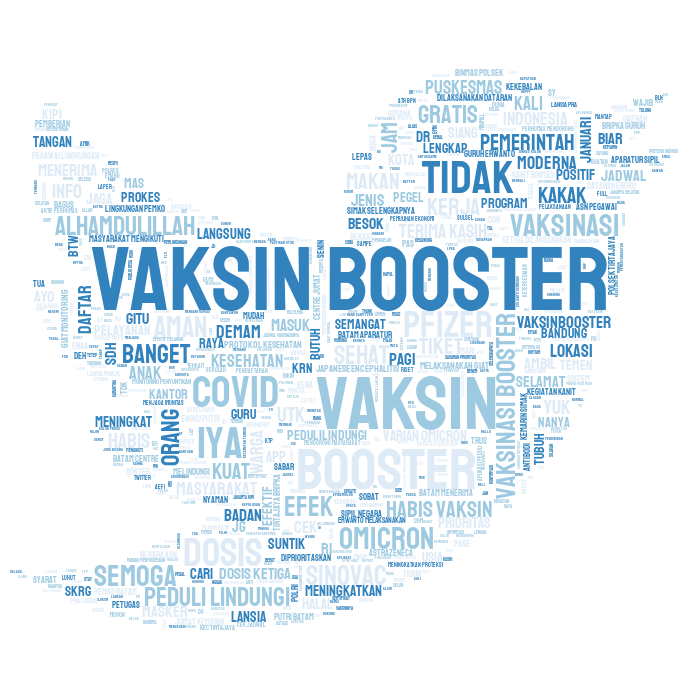

In [ ]:
#Word Cloud Data Sentimen Positif
stylecloud.gen_stylecloud(text=' '.join(tweet_positif),
                          size=700,
                          output_name='positive_clouds.png',
                          palette='colorbrewer.sequential.Blues_3',
                          icon_name='fab fa-twitter' #  set icon style
                         )

Image(filename='positive_clouds.png')

**Word Cloud Positif**  
Disini dapat terlihat kata-kata yang tergolong positif seperti :
* aman
* kesehatan
* prioritas
* sehat
* gratis
* efektif
* halal


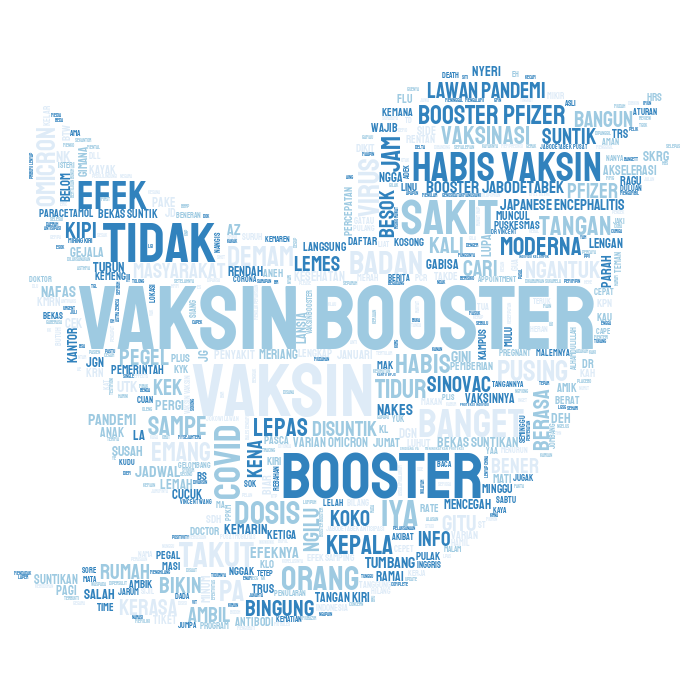

In [ ]:
#Word Cloud Data Sentimen Negatif
stylecloud.gen_stylecloud(text=' '.join(tweet_negatif),
                          size=700,
                          output_name='negative_clouds.png',
                          palette='colorbrewer.sequential.Blues_3',
                          icon_name='fab fa-twitter' #  set icon style
                         )

Image(filename='negative_clouds.png')

**Word Cloud Negatif**  
Disini dapat terlihat kata-kata yang tergolong negatif seperti :
* sakit
* pusing
* bingung
* pegel
* ngilu
* KIPI

# Data Analysis

Berdasarkan analisis yang sudah dijalankan, kita dapat mengetahui apakah dari data yang ada lebih banyak yang setuju atau tidak setuju dengan vaksin booster. Dari pengelolaan data diatas, kita sudah melakukan pengumpulan data, pembersihan data, dan prosesing data. Dengan hasil prosesing data dengan topic analysis, saya mendapat 7 topik yang masing-masing mewakili topik yang didapat dari twitter maupun berita. Setelah itu saya membuat analisis sentimen dimana hasil yang didapat adalah masyarakat cenderung sedikit positif dengan nilai rata-rata 0.05 dan standar deviasi 1.165.

Hal ini menunjukkan bahwa reaksi masyarakat terhadap vaksin booster masih tergolong positif. Sebanyak 365 data menyatakan respon positif, sementara ada sebanyak 299 data yang menyatakan respon negatif. Hal ini menandakan selisih data yang menyatakan respon positif dan negatif tidak terlalu jauh. Sementara data yang menyatakan respon netral ada pada 862 data.